# Football Match Prediction System

In [231]:
#import all the required libraries 
import pandas as pd 
import numpy as np
import requests
from bs4 import BeautifulSoup
import sklearn


## Data Load
###  <font color=darkblue>  Here I am Webscrapping fbref website for EPL stats.</font>
> I fetched the data from last 3 seasons.

In [ ]:
years = list(range(2022, 2019, -1))
all_matches = []

In [ ]:
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

In [ ]:
#I have to wait for 10 seconds before hitting every team link
import time
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]
    #fetching all the teams stats link from the competition page
    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    #fetching previous season link
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    #fetching team stats from seasons
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        #fetching scores and fixtures details
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        #fetching shooting details
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        #merging both the c
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(10)

In [ ]:
match_df = pd.concat(all_matches)


In [221]:
match_df.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
0,15-08-2021,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,NaN,18,4,16.9,1,0,0,2022,Manchester City
1,21-08-2021,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,NaN,16,4,17.3,1,0,0,2022,Manchester City
2,28-08-2021,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,NaN,25,10,14.3,0,0,0,2022,Manchester City
3,11-09-2021,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,NaN,25,8,14.0,0,0,0,2022,Manchester City
4,18-09-2021,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,NaN,16,1,15.7,1,0,0,2022,Manchester City


## EDA

In [5]:
match_df.shape
#38 matches per team*20 teams*3 seasons=2280

(2280, 28)

In [222]:
del match_df["Comp"]
del match_df["Notes"]

In [ ]:
match_df["Date"] = pd.to_datetime(match_df["Date"]);#parsing date 

## Preparing data for Model Deployment

In [224]:
match_df["venue_code"] = match_df["Venue"].astype("category").cat.codes#creating codes for venue

In [225]:
match_df["opp_code"] = match_df["Opponent"].astype("category").cat.codes#creating codes for opponent

In [226]:
match_df["hour"] = match_df["Time"].str.replace(":.+", "", regex=True).astype("int")#Time into hours term

In [227]:
match_df["day_code"] = match_df["Date"].dt.dayofweek

In [228]:
match_df["target"] = (match_df["Result"] == "W").astype("int")#considering win as 1 and loss or draw as 0

In [230]:
match_df.head()

,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,...,FK,PK,PKatt,Season,Team,venue_code,opp_code,hour,day_code,target
0,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0,1,Tottenham,1.9,...,1,0,0,2022,Manchester City,0,19,16,6,0
1,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5,0,Norwich City,2.7,...,1,0,0,2022,Manchester City,1,16,15,5,1
2,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5,0,Arsenal,3.8,...,0,0,0,2022,Manchester City,1,0,12,5,1
3,2021-11-09,15:00,Matchweek 4,Sat,Away,W,1,0,Leicester City,2.9,...,0,0,0,2022,Manchester City,0,11,15,1,1
4,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0,0,Southampton,1.1,...,1,0,0,2022,Manchester City,1,18,15,5,0


### Spliting data into train and test data set

In [16]:
train = match_df[match_df["Date"] < '2022-01-01']

In [17]:
test = match_df[match_df["Date"] >= '2022-01-01']

In [18]:
predictors = ["venue_code", "opp_code", "hour", "day_code"]

## Model Deployment

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
lr=LogisticRegression()

In [21]:
lr.fit(train[predictors], train["target"])

LogisticRegression()

In [22]:
lrpreds = lr.predict(test[predictors])

In [23]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(test["target"], lrpreds)


0.5989847715736041

In [26]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [27]:
precision_score(test['target'], lrpreds)

C:\Users\manda\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [28]:
from sklearn.metrics import plot_confusion_matrix

C:\Users\manda\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


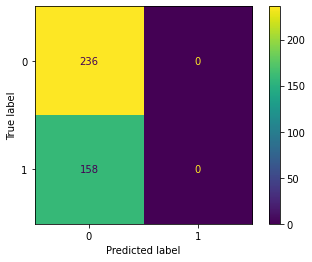

In [29]:
disp=plot_confusion_matrix(lr,test[predictors], test["target"]);

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
knn = KNeighborsClassifier(n_neighbors=3)

In [32]:
knn.fit(train[predictors], train["target"])


KNeighborsClassifier(n_neighbors=3)

In [33]:
knnpreds = knn.predict(test[predictors])

In [34]:
accuracy_score(test["target"], knnpreds)


0.6065989847715736

In [35]:
precision_score(test['target'], knnpreds)

0.514018691588785

C:\Users\manda\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


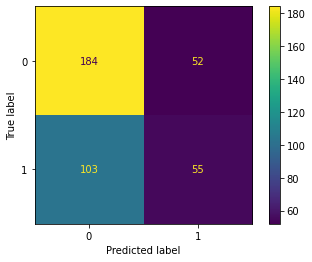

In [36]:
disp=plot_confusion_matrix(knn,test[predictors], test["target"]);

In [37]:
recall_score(test['target'], knnpreds)

0.34810126582278483

In [38]:
f1_score(test['target'], knnpreds)

0.4150943396226415

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10)


In [41]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50)

In [42]:
rfpreds=rf.predict(test[predictors])

In [43]:
accuracy_score(test['target'],rfpreds)

0.6116751269035533

In [44]:
precision_score(test['target'],rfpreds)

0.5268817204301075

In [45]:
recall_score(test['target'], rfpreds)

0.310126582278481

In [46]:
f1_score(test['target'], rfpreds)

0.3904382470119522

### <font color=darkblue>Observations</font>
>- We find that accuracy is high with all the models as Win cases are less compared to loss+draw.
>- But precision is 0 in case of Logistic regression and less than accuracy no. in case of knn and random forest.
>- To increase precision I will use rolling averages method.

### Rolling Averages

In [47]:
grouped_matches = match_df.groupby("Team")

In [48]:
#for each team we are checking their previous 3 weeks performance and assigning that value to 4th week
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [49]:
#these are the columns to consider for rolling avgs
cols = ["GF", "GA", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]
#these will be the new columns name with _rolling
new_cols = [f"{c}_rolling" for c in cols]

In [50]:
matches_rolling = grouped_matches.apply(lambda x: rolling_averages(x, cols, new_cols))


In [51]:
matches_rolling

Unnamed: 0       Date   Time         Round  Day  \
Team                                                                            
Arsenal                 1056          21 2019-05-12  20:15  Matchweek 15  Thu   
                        916           10 2019-06-10  14:00   Matchweek 8  Sun   
                        783            1 2019-08-17  12:30   Matchweek 2  Sat   
                        806            2 2019-08-24  17:30   Matchweek 3  Sat   
                        985           17 2019-09-11  17:30  Matchweek 12  Sat   
...                                  ...        ...    ...           ...  ...   
Wolverhampton Wanderers 376           38 2022-07-05  15:00  Matchweek 36  Sat   
                        373           35 2022-08-04  20:00  Matchweek 32  Fri   
                        363           25 2022-10-02  19:45  Matchweek 24  Thu   
                        369           31 2022-10-03  19:30  Matchweek 19  Thu   
                        377           39 2022-11-05  20:15  Matchweek 33  Wed   

                             Venue Result  GF  GA         Opponent  ...  \
Team                                                                ...   
Arsenal                 1056  Home      L   1   2         Brighton  ...   
                        916   Home      W   1   0      Bournemouth  ...   
                        783   Home      W   2   1          Burnley  ...   
                        806   Away      L   1   3        Liverpool  ...   
                        985   Away      L   0   2   Leicester City  ...   
...                            ...    ...  ..  ..              ...  ...   
Wolverhampton Wanderers 376   Away      D   2   2          Chelsea  ...   
                        373   Away      L   0   1    Newcastle Utd  ...   
                        363   Home      L   0   1          Arsenal  ...   
                        369   Home      W   4   0          Watford  ...   
                        377   Home      L   1   5  Manchester City  ...   

                              day_code  target  GF_rolling  GA_rolling  \
Team                                                                     
Arsenal                 1056         6       0    1.666667    1.666667   
                        916          0       1    1.333333    1.666667   
                        783          5       1    1.000000    1.000000   
                        806          5       0    1.333333    1.000000   
                        985          2       0    1.333333    1.333333   
...                                ...     ...         ...         ...   
Wolverhampton Wanderers 376          1       0    0.666667    2.000000   
                        373          3       0    1.333333    2.000000   
                        363          6       0    1.000000    2.000000   
                        369          0       1    0.666667    1.333333   
                        377          5       0    1.333333    0.666667   

                             Sh_rolling SoT_rolling Dist_rolling FK_rolling  \
Team                                                                          
Arsenal                 1056  17.000000    5.666667    15.033333   0.666667   
                        916   12.333333    4.666667    14.100000   0.333333   
                        783   11.333333    3.666667    14.933333   0.333333   
                        806   13.333333    5.333333    16.233333   0.333333   
                        985   12.333333    4.666667    17.700000   0.333333   
...                                 ...         ...          ...        ...   
Wolverhampton Wanderers 376   12.000000    4.666667    18.166667   0.666667   
                        373   12.666667    4.333333    16.433333   0.666667   
                        363    8.666667    3.666667    15.766667   0.000000   
                        369   11.333333    3.333333    17.133333   0.666667   
                        377   10.333333    3.666667    18.300000   0.666667   

         

In [52]:
matches_rolling = matches_rolling.droplevel('Team')

In [53]:
matches_rolling

,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,...,day_code,target,GF_rolling,GA_rolling,Sh_rolling,SoT_rolling,Dist_rolling,FK_rolling,PK_rolling,PKatt_rolling
1056,21,2019-05-12,20:15,Matchweek 15,Thu,Home,L,1,2,Brighton,...,6,0,1.666667,1.666667,17.000000,5.666667,15.033333,0.666667,0.333333,0.333333
916,10,2019-06-10,14:00,Matchweek 8,Sun,Home,W,1,0,Bournemouth,...,0,1,1.333333,1.666667,12.333333,4.666667,14.100000,0.333333,0.333333,0.333333
783,1,2019-08-17,12:30,Matchweek 2,Sat,Home,W,2,1,Burnley,...,5,1,1.000000,1.000000,11.333333,3.666667,14.933333,0.333333,0.000000,0.000000
806,2,2019-08-24,17:30,Matchweek 3,Sat,Away,L,1,3,Liverpool,...,5,0,1.333333,1.000000,13.333333,5.333333,16.233333,0.333333,0.000000,0.000000
985,17,2019-09-11,17:30,Matchweek 12,Sat,Away,L,0,2,Leicester City,...,2,0,1.333333,1.333333,12.333333,4.666667,17.700000,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,38,2022-07-05,15:00,Matchweek 36,Sat,Away,D,2,2,Chelsea,...,1,0,0.666667,2.000000,12.000000,4.666667,18.166667,0.666667,0.000000,0.000000
373,35,2022-08-04,20:00,Matchweek 32,Fri,Away,L,0,1,Newcastle Utd,...,3,0,1.333333,2.000000,12.666667,4.333333,16.433333,0.666667,0.000000,0.000000
363,25,2022-10-02,19:45,Matchweek 24,Thu,Home,L,0,1,Arsenal,...,6,0,1.000000,2.000000,8.666667,3.666667,15.766667,0.000000,0.000000,0.000000
369,31,2022-10-03,19:30,Matchweek 19,Thu,Home,W,4,0,Watford,...,0,1,0.666667,1.333333,11.333333,3.333333,17.133333,0.666667,0.000000,0.000000


### Againg Training our Model with this new Information

In [116]:
train = matches_rolling[matches_rolling["Date"] < '2022-01-01']
test = matches_rolling[matches_rolling["Date"] >= '2022-01-01']

In [56]:
predictors=predictors+new_cols

In [59]:
knn=KNeighborsClassifier(n_neighbors=3)

In [60]:
knn.fit(train[predictors],train['target'])

KNeighborsClassifier(n_neighbors=3)

In [61]:
knnpreds=knn.predict(test[predictors])

In [62]:
accuracy_score(test['target'],knnpreds)

0.5812182741116751

In [63]:
precision_score(test['target'],knnpreds)

0.472

In [64]:
recall_score(test['target'], knnpreds)

0.37341772151898733

In [65]:
f1_score(test['target'], knnpreds)

0.4169611307420495

In [66]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10)

In [67]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50)

In [68]:
rfpreds=rf.predict(test[predictors])

In [70]:
accuracy_score(test['target'],rfpreds)

0.6472081218274112

In [71]:
precision_score(test['target'],rfpreds)

0.6338028169014085

In [72]:
recall_score(test['target'], rfpreds)

0.2848101265822785

In [73]:
f1_score(test['target'], rfpreds)

0.39301310043668125

C:\Users\manda\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


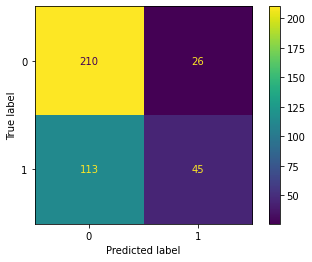

In [247]:
disp=plot_confusion_matrix(rf,test[predictors], test["target"])

### <font color=darkblue>Conclusions</font>
>- After using rolling averages we are able to improve our precision with random forest model.